# Check new colorimetry data

In [2]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
# use lasso from sklearn
from sklearn.linear_model import Lasso
from tqdm import tqdm
import seaborn as sns
from itertools import combinations
import math
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
# import pca from sklearn
from sklearn.decomposition import PCA

from tqdm import tqdm

RANDOM_SEED = 19890417

# load the data

In [3]:
# go through all the sheets in the excel file
def get_sheets(file):
    xls = pd.ExcelFile(file)
    sheets = xls.sheet_names
    return sheets

fname = "conc_w_chinmay.xlsx"
all_sheets = get_sheets(fname)
all_data_list = []
for sheet in all_sheets:
    data = pd.read_excel(fname, sheet_name=sheet, header=None, skiprows=1)
    data.columns = ["wavelength","abs"]
    # data["measurement"] = sheet
    data["conc"] = int(sheet.split("-")[0])
    data["replicate"] = int(sheet.split("-")[1])
    all_data_list.append(data)
new_data = pd.concat(all_data_list, ignore_index=True)
new_data

,wavelength,abs,conc,replicate
0,345.572,-1941.98637,0,1
1,345.788,-1941.98637,0,1
2,346.003,-1941.98637,0,1
3,346.219,-1931.74652,0,1
4,346.435,-1958.37012,0,1
...,...,...,...,...
43771,1042.590,1037.80816,100,3
43772,1042.752,728.56488,100,3
43773,1042.914,-618.99855,100,3
43774,1043.076,-389.62605,100,3


In [4]:
43776/3

14592.0

In [5]:
avged_data = new_data.groupby(["wavelength","conc"]).mean().reset_index()
del avged_data["replicate"]
avged_data.sort_values(by=["conc","wavelength"], inplace=True)

<Axes: xlabel='wavelength', ylabel='abs'>

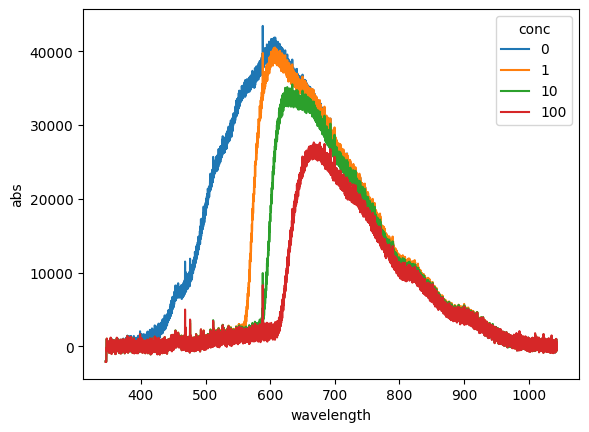

In [6]:
sns.lineplot(data=avged_data, x="wavelength", y="abs", hue="conc", palette="tab10")

# smooth the signal

<Axes: xlabel='wavelength', ylabel='smoothed_abs'>

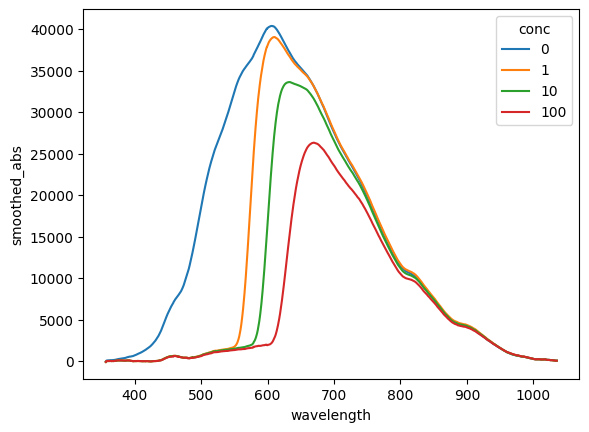

In [7]:
# for each concentration smooth the abs values using a rolling mean

avged_data["smoothed_abs"] = avged_data.groupby("conc")["abs"].transform(lambda x: x.rolling(100, center=True).mean())
sns.lineplot(data=avged_data.dropna(how="any"), x="wavelength", y="smoothed_abs", hue="conc", palette="tab10")

In [8]:
smoothed_data = pd.DataFrame(avged_data.dropna(how="any"))
print(smoothed_data.shape)

(14196, 4)


# Transform the data into a ML ready form

In [9]:
# transform the wavelength and conc columns to wide format
smoothed_data["wavelength_names"] = [f"wv_{wv}" for wv in smoothed_data["wavelength"]]
smoothed_data["conc"] = smoothed_data["conc"].astype(str)

smoothed_data_wide = smoothed_data.pivot(index="wavelength_names", columns="conc", values="smoothed_abs").transpose().reset_index()

In [10]:
smoothed_data_wide

wavelength_names,conc,wv_1000.141,wv_1000.308,wv_1000.475,wv_1000.642,wv_1000.809,wv_1000.976,wv_1001.142,wv_1001.309,wv_1001.476,...,wv_998.471,wv_998.639,wv_998.806,wv_998.973,wv_999.14,wv_999.307,wv_999.474,wv_999.641,wv_999.807,wv_999.974
0,0,259.209129,253.993636,254.205259,246.859878,243.371504,237.364129,235.432212,235.377600,229.807125,...,293.048400,294.509284,288.501909,285.907815,281.975715,275.879595,271.572034,272.090853,264.165214,261.106914
1,1,258.180594,253.142591,254.200708,246.589091,241.851456,236.417512,234.383197,234.676739,228.252944,...,294.422814,295.446798,288.770420,286.285551,282.182787,276.339250,271.458258,272.536855,263.914906,259.784836
2,10,265.564659,260.547136,261.113740,252.519098,248.115965,240.292725,238.429073,239.446231,233.240886,...,302.769425,304.380494,297.929392,295.041756,290.188070,284.105603,280.180330,280.903945,273.128490,267.510229
3,100,266.122161,259.944122,262.347072,254.674016,249.506308,242.304285,239.887682,241.116463,233.409274,...,303.081171,304.937996,297.510696,294.431916,289.366607,283.215874,279.666061,280.860710,272.197802,267.030094


# find the single best predictor using LOO CV

In [11]:
all_results = []
for leave_out in range(4):
    for feat in tqdm(smoothed_data_wide.columns):
        if feat[:3] == "wv_":
            X = list(smoothed_data_wide[feat])
            y = list(map(int,smoothed_data_wide.conc))

            X_train = [[v] for i,v in enumerate(X) if i != leave_out]
            y_train = [v for i,v in enumerate(y) if i != leave_out]
            X_test = [[X[leave_out]]]
            y_test = [y[leave_out]]

            model = LinearRegression()
            #print(X_train, y_train, X_test, y_test)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            datum = {"hold_out":leave_out, "feature":feat, "pred":y_pred[0], "true":y_test[0]}
            all_results.append(datum)
pd.DataFrame(all_results)

100%|██████████| 3550/3550 [00:04<00:00, 824.59it/s]


,hold_out,feature,pred,true
0,0,wv_1000.141,5.757361,0
1,0,wv_1000.308,10.745578,0
2,0,wv_1000.475,-5.476774,0
3,0,wv_1000.642,-6.840088,0
4,0,wv_1000.809,7.628577,0
...,...,...,...,...
14191,3,wv_999.307,8.953784,100
14192,3,wv_999.474,9.429461,100
14193,3,wv_999.641,9.965215,100
14194,3,wv_999.807,9.012469,100


In [12]:
all_raw_results = pd.DataFrame(all_results)

processed_results = []

for feat in tqdm(set(all_raw_results["feature"])):
    sub_df = pd.DataFrame(all_raw_results[all_raw_results["feature"] == feat])

    # calculate the mse and R2 for the sub_df using the pred and true columns
    mse = mean_squared_error(sub_df["true"], sub_df["pred"])
    r2 = r2_score(sub_df["true"], sub_df["pred"])
    processed_results.append({"feature":feat, "mse":mse, "r2":r2})

processed_results_df = pd.DataFrame(processed_results)
processed_results_df.sort_values(by=["mse"], inplace=True)

100%|██████████| 3549/3549 [00:16<00:00, 221.37it/s]


In [13]:
processed_results_df.head(5)

,feature,mse,r2
3246,wv_633.443,370.501978,0.788910
13,wv_633.642,370.946775,0.788657
1526,wv_632.052,371.111926,0.788563
2039,wv_632.847,371.328276,0.788440
2896,wv_632.251,371.583864,0.788294


# now use PC to decompose the entire spectrum into 3 variables and try it

In [14]:
features = list(col for col in smoothed_data_wide.columns if "wv_" == col[:3])

for loo_index in range(4):
    training_indices = [i for i in range(4) if i != loo_index]
    X_train = smoothed_data_wide[features].iloc[training_indices]
    y_train = smoothed_data_wide["conc"].iloc[training_indices].astype(int).values
    X_test = smoothed_data_wide[features].iloc[loo_index]
    y_test = [int(smoothed_data_wide["conc"].iloc[loo_index])]

    pc = PCA(n_components=3, svd_solver='full')
    pc.fit(X_train)
    X_train_pca = pc.transform(X_train)
    X_test_pca = pc.transform([X_test])


c:\Users\craut\.virtualenvs\colorimetry_ML-6CtRR2jE\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\craut\.virtualenvs\colorimetry_ML-6CtRR2jE\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\craut\.virtualenvs\colorimetry_ML-6CtRR2jE\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\craut\.virtualenvs\colorimetry_ML-6CtRR2jE\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [15]:
X_train

wavelength_names,wv_1000.141,wv_1000.308,wv_1000.475,wv_1000.642,wv_1000.809,wv_1000.976,wv_1001.142,wv_1001.309,wv_1001.476,wv_1001.643,...,wv_998.471,wv_998.639,wv_998.806,wv_998.973,wv_999.14,wv_999.307,wv_999.474,wv_999.641,wv_999.807,wv_999.974
0,259.209129,253.993636,254.205259,246.859878,243.371504,237.364129,235.432212,235.377600,229.807125,229.868564,...,293.048400,294.509284,288.501909,285.907815,281.975715,275.879595,271.572034,272.090853,264.165214,261.106914
1,258.180594,253.142591,254.200708,246.589091,241.851456,236.417512,234.383197,234.676739,228.252944,228.683017,...,294.422814,295.446798,288.770420,286.285551,282.182787,276.339250,271.458258,272.536855,263.914906,259.784836
2,265.564659,260.547136,261.113740,252.519098,248.115965,240.292725,238.429073,239.446231,233.240886,234.544759,...,302.769425,304.380494,297.929392,295.041756,290.188070,284.105603,280.180330,280.903945,273.128490,267.510229
